# 10-5-3 network multimodal dataset 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
import FFNetwork as FF
import Layer
import importlib
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy
importlib.reload(NN)
importlib.reload(Layer);

In [2]:
def ClassPlot(x, labels=[], idx=(1,2)):
    if len(labels)>0:
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = np.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(x[:,idx[0]], x[:,idx[1]], color=colours, marker='.')
    else:
        plt.scatter(x[:,idx[0]], x[:,idx[1]], marker='.')
    plt.axis('equal');

## Create a simple dataset

In [211]:
# This creates a dataset

n_classes = 3
hidden_dim = 5
sensory_dim = 10

seed = 4896
torch.manual_seed(seed)
np.random.seed(seed)
B = np.eye(n_classes)
X = 3.*(np.random.rand(sensory_dim, n_classes) - 0.5)
A = X.T
print('Bottom vectors')
print(B)
print('Top vectors')
print(A)
#print('System matrix:\n'+str(M))

Bottom vectors
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Top vectors
[[ 2.81545125e-01  4.66284464e-01  1.17578046e+00  2.80777722e-01
  -9.98590398e-01 -1.34068038e+00 -1.22477599e+00 -4.35146799e-01
  -1.00668904e+00  1.22099385e+00]
 [ 1.27140329e+00  7.51001898e-01  6.46658821e-02 -3.09697092e-02
  -1.53034832e-01 -4.57793366e-01  9.34368604e-01  7.71819893e-01
   1.44365010e+00 -9.80089022e-01]
 [ 1.13260480e+00 -1.41664573e+00 -2.49025374e-01 -7.68324958e-01
   5.30640389e-01 -2.12854585e-01  1.14924141e-03 -1.08392019e+00
  -3.72873557e-01  7.83174609e-01]]


In [228]:
# Use A and B to make a dataset
def MakeDataset(A, B, n=300, noise=0.2):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes

    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(n_classes)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

# Use A and B to make a dataset
def MakeTwoClustersDataset(A, B, mode, n=200, noise=0.2):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes-1

    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(bottom_dim)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))
            
        if mode == 1:
            if r == 0:
                training_input.append(B[r])
                training_output.append(A[r+2]+noise*np.random.normal(size=np.shape(A[r+2])))
        else:
            if r == 1:
                training_input.append(B[r])
                training_output.append(A[r+1]+noise*np.random.normal(size=np.shape(A[r+1])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

In [231]:
B = np.eye(2)
train = MakeTwoClustersDataset(A, B, mode=0)

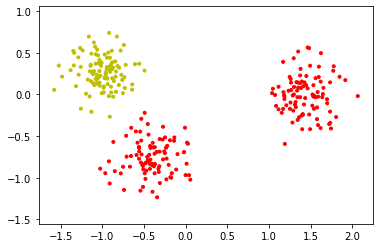

In [232]:
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=(8,3))

In [9]:
# initial_weights_0 = np.load('initial_weights_0.npy')
# initial_weights_1 = np.load('initial_weights_1.npy')

In [357]:
n_classes = 2

# Create a network
ffnet = FF.Network()

af = 'identity'#'logistic'
ffnet.AddLayer(FF.Layer(n_nodes=sensory_dim, act=af))
ffnet.AddLayer(FF.Layer(n_nodes=hidden_dim, act=af))
ffnet.AddLayer(FF.Layer(n_nodes=n_classes, act=af))

cost = 'MSE'#'cross-entropy'
ffnet.SetCostFunction(cost)

initial_weights_0 = deepcopy(ffnet.W[0])
initial_weights_1 = deepcopy(ffnet.W[1])

for w in ffnet.W:
    print(w)

[[-2.31463167e+00 -6.98833240e-01  1.64209072e+00 -2.57006499e+00
   6.00431717e-01]
 [-2.39755872e-01 -4.54717678e-01 -7.32541349e-01 -5.44899800e-01
  -8.52755219e-01]
 [-2.01668317e+00 -2.43063097e+00  1.08230828e+00  1.31909550e+00
   1.22631527e+00]
 [ 1.02857691e+00 -1.83273009e+00  4.63720720e-02  4.39476477e-02
  -1.26304704e+00]
 [-7.60841637e-02 -1.69315863e+00  4.40430050e-02 -1.42652625e+00
  -2.97738332e-01]
 [-4.70847927e-01 -1.39233134e+00 -4.46826426e-04 -2.27918043e+00
   8.10583722e-01]
 [ 2.07409304e+00 -9.52375654e-01 -1.39710660e+00 -4.56319371e-01
  -8.78157760e-01]
 [ 7.90026391e-01  3.10607336e+00 -3.15920221e-01  2.46428024e-01
  -3.58251419e-01]
 [-1.63511457e+00 -1.70267287e+00 -1.39051207e-01 -2.22634386e+00
   1.70494305e+00]
 [-1.85474593e+00  3.82351016e-01  6.19861842e-01  1.65477062e+00
  -2.77055178e-02]]
[[-0.4222799   2.01516361]
 [-0.84222685  0.26580799]
 [-0.50892757 -1.82904013]
 [-0.93631197  1.16354128]
 [ 1.21361941  3.32660813]]


In [383]:
ffnet.W[0] = initial_weights_0
ffnet.W[1] = initial_weights_1
w_decay= 0.0 #0.004
progress = ffnet.SGD(train[1].cpu().numpy(), train[0].cpu().numpy(), lrate=0.01, weight_decay=w_decay, bias_decay=0.0, epochs=20, batch_size=4, shuffle=False)
FF.ClassificationAccuracy(ffnet.FeedForward(train[1].cpu().numpy()), train[0].cpu().numpy())

Epoch 0: Cost = 0.4115878583195909
Epoch 1: Cost = 0.19072344235495628
Epoch 2: Cost = 0.10144995418032127
Epoch 3: Cost = 0.05951545896483989
Epoch 4: Cost = 0.038732929138532275
Epoch 5: Cost = 0.028308919447051432
Epoch 6: Cost = 0.023170932538705995
Epoch 7: Cost = 0.02076773331238163
Epoch 8: Cost = 0.01976990025337965
Epoch 9: Cost = 0.01947400996652318
Epoch 10: Cost = 0.019507712200008243
Epoch 11: Cost = 0.019676550262989694
Epoch 12: Cost = 0.019882071685481294
Epoch 13: Cost = 0.02007735532594107
Epoch 14: Cost = 0.020242701984451644
Epoch 15: Cost = 0.02037235821885318
Epoch 16: Cost = 0.020467323095178215
Epoch 17: Cost = 0.02053151450886554
Epoch 18: Cost = 0.020569784785304555
Epoch 19: Cost = 0.020586945248818607


1.0

## Create a Neural Network

In [347]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=n_classes))
net.AddLayer(Layer.PELayer(n=hidden_dim))
net.AddLayer(Layer.TopPELayer(n=sensory_dim))

sym = False
af = 'identity'
net.Connect(0, 1, act=af, symmetric=sym)
net.Connect(1, 2, act=af, symmetric=sym)

net.SetTau(0.2)
net.learning_tau = 0.1
net.learn_biases = False

net.connections[0].M = torch.tensor(initial_weights_1).float().to(device)
net.connections[0].W = net.connections[0].M.transpose(1,0)

net.connections[1].M = torch.tensor(initial_weights_0).float().to(device)
net.connections[1].W = net.connections[1].M.transpose(1,0)

identity
identity


In [512]:
#If you want to look at PC network training on multimodal dataset

net.SetWeightDecay(0.01)
net.SetvDecay(0.0)
net.learning_blackout=1.0
net.blackout_interval=0.0
net.Learn(train[0], train[1], T=4., dt=0.001, epochs=10, batch_size=4, shuffle=False)

FloatProgress(value=0.0, max=280.0)

# Test Generation

In [348]:
classes = torch.eye(n_classes).to(device)
print(classes)

tensor([[1., 0.],
        [0., 1.]], device='cuda:0')


In [384]:
netx = net
netx.connections[1].SetM(ffnet.W[0])
netx.connections[1].SetW(ffnet.W[0].T)
netx.connections[0].SetM(ffnet.W[1])
netx.connections[0].SetW(ffnet.W[1].T)
netx.layers[1].SetBias(ffnet.lyr[1].b)
netx.layers[0].SetBias(ffnet.lyr[2].b)

In [385]:
netx.Reset()
netx.SetvDecay(0.01)
z2 = netx.Predict(20., classes.to(device), dt=0.001)

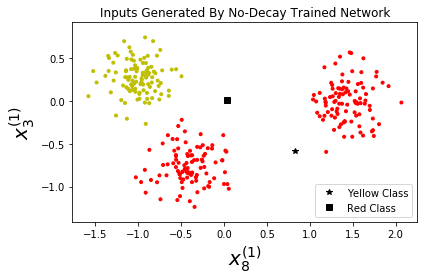

In [386]:
lgnd = ['Yellow Class', 'Red Class']

idx=(8,3)
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=idx)

plt.plot(np.array(z2[0,idx[0]].cpu()), np.array(z2[0,idx[1]].cpu()), 'k*')
plt.plot(np.array(z2[1,idx[0]].cpu()), np.array(z2[1,idx[1]].cpu()), 'ks')
plt.xlabel('$x_8^{(1)}$', fontsize=20)
plt.ylabel('$x_3^{(1)}$', fontsize=20)
# plt.axis(a)
plt.legend(lgnd)

#plt.title('Inputs Generated By Decay Trained Network')
#plt.tight_layout()
#plt.savefig("multimodal_with_decay.pdf", format='pdf')

plt.title('Inputs Generated By No-Decay Trained Network')
plt.tight_layout()
plt.savefig("multimodal_no_decay.pdf", format='pdf')

a = plt.axis()

In [70]:
print(a)

(-1.9128161349285748, 1.6354509272564557, -1.6211928764944081, 0.5943856875066762)
